In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [225]:
data=pd.read_csv('clinical features+y.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'clinical features+y.csv'

In [5]:
#survival status was isolated
data_y=data[['vital_status','survival_in_days']].copy()

#convert data_y to a structured array
data_y=data_y.to_records(column_dtypes={"vital_status":"?"},index=False)


In [6]:
#save a new array of only vital status for stratification
strat=data[['vital_status']].copy()
strat=strat.to_records(column_dtypes={"vital_status":"?"},index=False)


rec.array([(False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), ( True,), (False,), (False,),
           (False,), (False,), (False,), ( True,), (False,), (False,),
           (False,), (False,), ( True,), (False,), (False,), (False,),
           (False,), (False,), ( True,), (False,), (False,), (False,),
           (False,), (False,), (False,), ( True,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), ( True,),
           ( True,), (False,), (False,), (False,), (False,), ( True,),
           (False,), (False,), (False,), (False,), (False,), (False,),
           (False,), (False,), (False,), (False,), (False,), (False,),
      

In [7]:
#Generate data_x
data_x=data.drop(['bcr_patient_barcode','vital_status','survival_in_days'],axis=1)

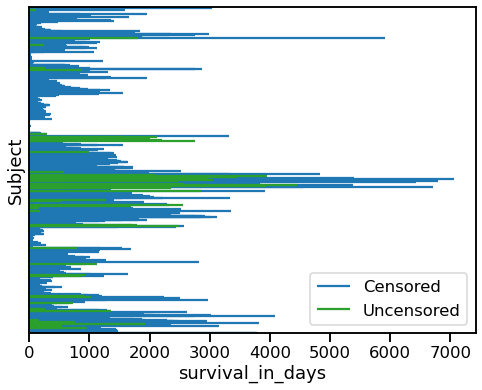

In [209]:
#censoring of the data
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

n_patients=data.shape[0]
patients=np.arange(n_patients)

ax.hlines(
    patients[data.vital_status == 0], 0, data[data.vital_status == 0].survival_in_days, 
    color=blue, label="Censored"
)

ax.hlines(
    patients[data.vital_status == 1], 0, data[data.vital_status == 1].survival_in_days, 
    color=red, label="Uncensored"
)


ax.set_xlim(left=0)
ax.set_xlabel("survival_in_days")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="lower right");


fig.savefig('censoring')

#fit_and_score _features

def fit_and_score_features(x, y):
    n_features = x.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(ties='efron')
    for j in range(n_features):
        Xj = x.iloc[:, j:j+1]
        m.fit(Xj,y)
        scores[j] = m.score(Xj,y)
    return scores

scores = fit_and_score_features(data_x, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

In [9]:
#split the model
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=42)

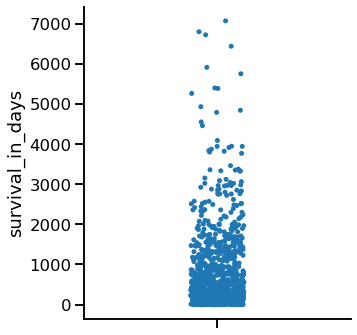

In [210]:
import seaborn as sns
survivaldays=sns.catplot(y="survival_in_days", data=data)


survivaldays.savefig('survival days.png')

In [13]:
#train-test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=42)

In [14]:
#Random survival forest (CL-RSF)
from sksurv.ensemble import RandomSurvivalForest
rsf=RandomSurvivalForest(n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        max_features='sqrt',
                        n_jobs=-1,
                        random_state=42)
rsf.fit(x_train,y_train)

rsf.score(x_test,y_test)

0.7520525451559934

In [128]:
#To randomly split the dataset with stratification and fit the RSF model (CL-RSF)
conlyrecords=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 sx_train,sx_test,sy_train,sy_test=train_test_split(data_x,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(sx_train,sy_train)
 conlyrecords.iloc[i-42,0]=rsf.score(sx_test,sy_test)
 conlyrecords.iloc[i-42,1]=rsf.score(sx_train,sy_train)


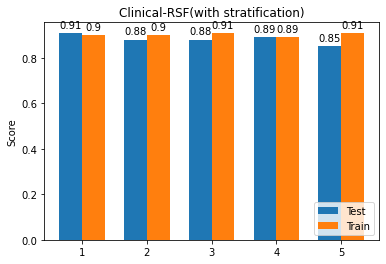

In [165]:
#plot the scores
labels=['1','2','3','4','5']
x=np.arange(len(labels))
width=0.35

fig,ax=plt.subplots()
rects1=ax.bar(x-width/2,np.round(conlyrecords['test score'],2),
              width,label='Test')
rects2=ax.bar(x+width/2,np.round(conlyrecords['train score'],2),
              width,label='Train')

ax.set_ylabel('Score')
ax.set_title('Clinical-RSF(with stratification)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=4)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)


plt.show()

In [82]:
#include TIIC data
cells=pd.read_csv('E:/Y3 SEM2/CS4220/Project/CIBERSORT.Output_Job4.csv')
cells=cells.sort_values(by=['Input Sample'])
cells=cells.drop(['Input Sample'],axis=1)
cells=cells.drop(["P-value","Pearson Correlation","RMSE"],axis=1)

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
436,0.163514,0.0,0.125726,0.031051,0,0.032553,0.000000,0.031229,0.052758,0.000000,...,0.000000,0.184920,0.040579,0.260902,0.008071,0.000000,0.045618,0.0,0.0,0.008330
645,0.026535,0.0,0.002263,0.146543,0,0.213623,0.010506,0.061948,0.062993,0.015586,...,0.000000,0.221950,0.103796,0.062647,0.000000,0.034762,0.035095,0.0,0.0,0.001752
433,0.082361,0.0,0.019830,0.211139,0,0.185140,0.028396,0.018098,0.071896,0.000000,...,0.000000,0.178111,0.071486,0.114387,0.000000,0.000000,0.019158,0.0,0.0,0.000000
466,0.059360,0.0,0.007169,0.147073,0,0.256614,0.006647,0.029809,0.010244,0.000000,...,0.026471,0.067364,0.088859,0.136827,0.017657,0.000000,0.088808,0.0,0.0,0.000000
112,0.045901,0.0,0.013257,0.067072,0,0.209942,0.000000,0.070571,0.005324,0.000000,...,0.020414,0.137158,0.077281,0.186247,0.003476,0.011387,0.126248,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,0.090068,0.0,0.009526,0.079382,0,0.100526,0.014386,0.117280,0.016399,0.000000,...,0.000000,0.196089,0.056737,0.162112,0.040547,0.033008,0.074153,0.0,0.0,0.000000
958,0.141980,0.0,0.022749,0.125724,0,0.251630,0.041777,0.000000,0.006963,0.000000,...,0.003120,0.131413,0.060523,0.120492,0.000000,0.000900,0.092697,0.0,0.0,0.000000
144,0.152378,0.0,0.066398,0.076364,0,0.277219,0.013185,0.000000,0.021180,0.000000,...,0.012091,0.099863,0.079194,0.142459,0.000000,0.000000,0.041422,0.0,0.0,0.000900
260,0.116900,0.0,0.034830,0.183989,0,0.058776,0.008930,0.035683,0.027816,0.000000,...,0.052850,0.141588,0.015652,0.171387,0.008498,0.000000,0.095280,0.0,0.0,0.000000


In [83]:
#combine clinical data and cibersort data
combined=pd.concat([data_x,cells],axis=1)

In [84]:
#split the dataset into train/test
cx_train,cx_test,cy_train,cy_test=train_test_split(
    combined,data_y,train_size=0.8,test_size=0.2,random_state=42)

In [90]:
#To randomly stratified split the data with five iterations (CT-RSF)
records=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 scx_train,scx_test,scy_train,scy_test=train_test_split(combined,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(scx_train,scy_train)
 records.iloc[i-42,0]=rsf.score(scx_test,scy_test)
 records.iloc[i-42,1]=rsf.score(scx_train,scy_train)



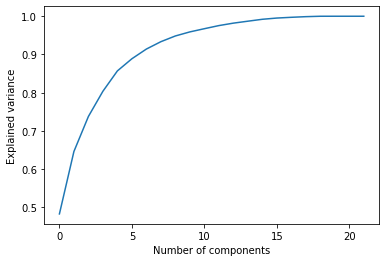

In [92]:
#perform PCA on TIICs
from sklearn.decomposition import PCA

pca_22=PCA(n_components=22,random_state=42)
pca_22.fit(cells)
arrcell_pca_22=pca_22.transform(cells)

plt.plot(np.cumsum(pca_22.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel('Explained variance')
plt.savefig('elbow_plot.png',dpi=100)

In [93]:
print("Variance explained by the First Principal component=",
      np.cumsum(pca_22.explained_variance_ratio_*100)[0])
print("Variance explained by the Second Principal component=",
      np.cumsum(pca_22.explained_variance_ratio_*100)[1])
print("Variance explained by the Third Principal component=",
      np.cumsum(pca_22.explained_variance_ratio_*100)[2])
print("Variance explained by the Tenth Principal component=",
      np.cumsum(pca_22.explained_variance_ratio_*100)[9])
#The first 10 components have explained 95.9% of variability

Variance explained by the First Principal component= 48.30014197981332
Variance explained by the Second Principal component= 64.62410778220404
Variance explained by the Third Principal component= 73.78716319407812
Variance explained by the Tenth Principal component= 95.90457747266747


In [94]:
#see how the performance can change when varying the number of principal components
scores=pd.Series(float)
for n in range (1,23):
    pca=PCA(n_components=n,random_state=42)
    pca.fit(cells)
    arrcell_pca=pca.transform(cells)
    cell_pca=pd.DataFrame(arrcell_pca)
    combined_pca=pd.concat([data_x,cell_pca],axis=1)

    
    cnx_train,cnx_test,cny_train,cny_test=train_test_split(
    combined_pca,data_y,train_size=0.8,test_size=0.2,random_state=42)
    
    rsf.fit(cnx_train,cny_train)

    scores[n]=rsf.score(cnx_test,cny_test)
    
  

In [95]:
scores=scores.drop([0])

Text(0.5, 1.0, 'Impact of TIIC PCA on the performance of RSF')

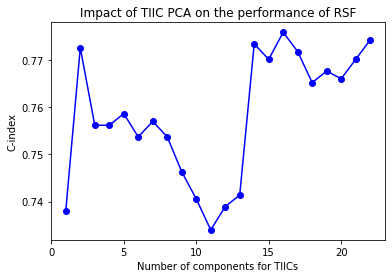

In [96]:
x=np.arange(1,23)
plt.plot(x,scores,'b-o')
plt.xlabel("Number of components for TIICs")
plt.ylabel("C-index")
plt.title("Impact of TIIC PCA on the performance of RSF")

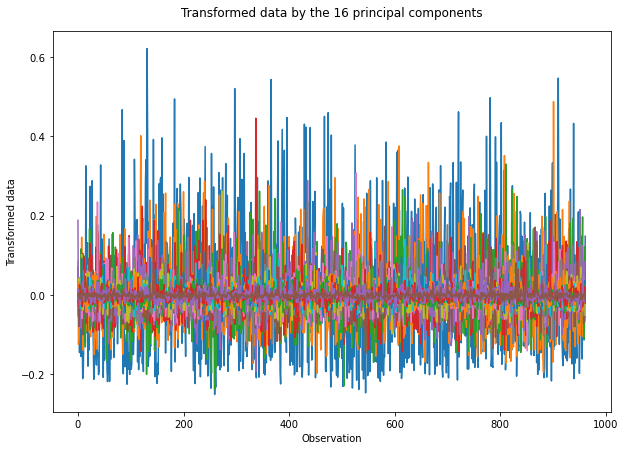

In [97]:
#Apply PCA by setting n_components=16
pca_16=PCA(n_components=16,random_state=42)
pca_16.fit(cells)
arrcell_pca_16=pca_16.transform(cells)

plt.figure(figsize=(10,7))
plt.plot(arrcell_pca_16)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
plt.title('Transformed data by the 16 principal components',pad=15)

plt.savefig('16 components.png')

In [98]:
#save the transformed array as a new dataframe
cells_new=pd.DataFrame(arrcell_pca_16,columns=['PC1','PC2','PC3','PC4','PC5',
                                              'PC6','PC7','PC8','PC9','PC10',
                                              'PC11','PC12','PC13','PC14','PC15','PC16'])
#combine the cells_new with clinical data
combined_new=pd.concat([data_x,cells_new],axis=1)

#split the train and test
cnx_train,cnx_test,cny_train,cny_test=train_test_split(
    combined_new,data_y,train_size=0.8,test_size=0.2,random_state=42)

In [105]:
#to randomly stratified split the dataset in five iterations and fit CTPCA-RSF
nrecords=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 scnx_train,scnx_test,scny_train,scny_test=train_test_split(combined_new,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(scnx_train,scny_train)
 nrecords.iloc[i-42,0]=rsf.score(scnx_test,scny_test)
 nrecords.iloc[i-42,1]=rsf.score(scnx_train,scny_train)

In [107]:
#cross-validation of RSF
#look at the parameters currently used
from pprint import pprint
pprint(rsf.get_params())

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#try to adjust number of trees, max_features, min_samples_leaf, min_samples_split
from sklearn.model_selection import RandomizedSearchCV
n_estimators=[int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features=['log2','sqrt','None']
min_samples_leaf=[10,15,20]
min_samples_split=[5,10,15]

#create the random grid
random_grid={'n_estimators':n_estimators,
            'max_features': max_features,
            'min_samples_leaf': min_samples_leaf,
            'min_samples_split':min_samples_split}
pprint(random_grid)

In [ ]:
#Use the random grid to search for beast hyperparameters
rsf_random=RandomizedSearchCV(estimator=rsf,param_distributions=random_grid,n_iter=150,
                             cv=5,verbose=2,random_state=42,n_jobs=-1)
rsf_random.fit(cnx_train,cny_train)

In [ ]:
#get the best hyperparameters
rsf_random.best_params_

In [ ]:
rsf_random.cv_results_

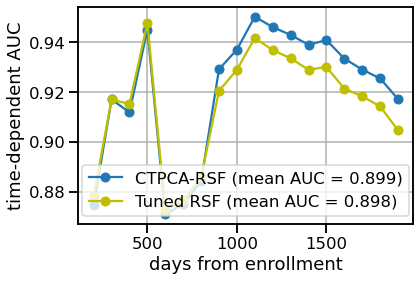

In [223]:
#Compare the performance of CTPCA-RSF and Tuned-RSF
from sksurv.metrics import cumulative_dynamic_auc
va_times=np.arange(start=200,stop=2000,step=100)

rsf.fit(scnx_train,scny_train)
clinical_PCA_estimate=rsf.predict(scnx_test)
clinical_PCA_auc,clinical_PCA_mean_auc=cumulative_dynamic_auc(scny_train,
                                                             scny_test,
                                                             clinical_PCA_estimate,
                                                             va_times)
best_random.fit(scnx_train,scny_train)
best_estimate=best_random.predict(scnx_test)
best_auc,best_mean_auc=cumulative_dynamic_auc(scny_train,scny_test,
                                                          best_estimate,va_times)
                                                          

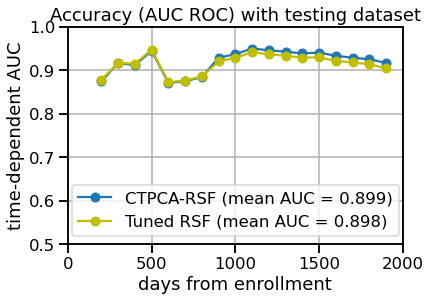

In [224]:
plt.plot(va_times, clinical_PCA_auc, "o-", 
         label="CTPCA-RSF (mean AUC = {:.3f})".format(clinical_PCA_mean_auc))
plt.plot(va_times, best_auc, "yo-", 
         label="Tuned RSF (mean AUC = {:.3f})".format(best_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.xlim(0,2000)
plt.ylim(0.5,1)
plt.title('Accuracy (AUC ROC) with testing dataset')
plt.legend(loc="lower center")
plt.grid(True)

In [114]:
#import expression level of certain oncogenes and tumor surpressor genes
gene=pd.read_csv('E:/Y3 SEM2/CS4220/Project/prognostic genes.csv')
gene=gene.sort_values(by=['uuid'])
gene=gene.drop(['filename','case_id','uuid'],axis=1)

In [115]:
#combine clinical features, TIIC and genes
combined_g=pd.concat([combined,gene],axis=1)

In [117]:
#stratify split the data and fit with five iterations (CTG-RSF)

records_g=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 scxg_train,scxg_test,scyg_train,scyg_test=train_test_split(combined_g,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(scxg_train,scyg_train)
 records_g.iloc[i-42,0]=rsf.score(scxg_test,scyg_test)
 records_g.iloc[i-42,1]=rsf.score(scxg_train,scyg_train)


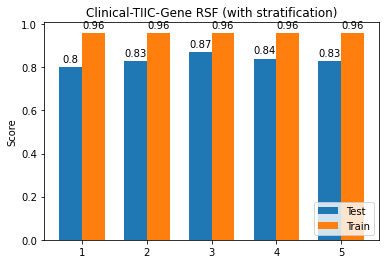

In [156]:
#plot the scores
labels=['1','2','3','4','5']
x=np.arange(len(labels))
width=0.35

fig,ax=plt.subplots()
rects1=ax.bar(x-width/2,np.round(records_g['test score'],2),
              width,label='Test')
rects2=ax.bar(x+width/2,np.round(records_g['train score'],2),
              width,label='Train')

ax.set_ylabel('Score')
ax.set_title('Clinical-TIIC-Gene RSF (with stratification)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=4)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)


plt.show()

In [130]:
#combining clinical and gene
clcombinedg=pd.concat([data_x,gene],axis=1)

In [132]:
#stratify split the data and fit with five iterations (CG-RSF)

clrecordsg=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 clxg_train,clxg_test,clyg_train,clyg_test=train_test_split(clcombinedg,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(clxg_train,clyg_train)
 clrecordsg.iloc[i-42,0]=rsf.score(clxg_test,clyg_test)
 clrecordsg.iloc[i-42,1]=rsf.score(clxg_train,clyg_train)


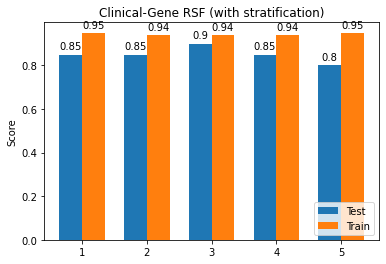

In [173]:
#plot the scores
labels=['1','2','3','4','5']
x=np.arange(len(labels))
width=0.35

fig,ax=plt.subplots()
rects1=ax.bar(x-width/2,np.round(clrecordsg['test score'],2),
              width,label='Test')
rects2=ax.bar(x+width/2,np.round(clrecordsg['train score'],2),
              width,label='Train')

ax.set_ylabel('Score')
ax.set_title('Clinical-Gene RSF (with stratification)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=4)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)


plt.show()

In [119]:
#combine clinical, PCAed-TIIC and genes
combinedn_g=pd.concat([combined_new,gene],axis=1)

In [121]:
#stratify split the data and fit with five iterations (CTPCAG-RSF)

recordsn_g=pd.DataFrame(np.array([[0,0], [0,0],[0,0],[0,0],[0,0]]),
                   columns=['test score', 'train score'])
for i in range(42,47):
 scxng_train,scxng_test,scyng_train,scyng_test=train_test_split(combinedn_g,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=i,stratify=strat)
 rsf.fit(scxng_train,scyng_train)
 recordsn_g.iloc[i-42,0]=rsf.score(scxng_test,scyng_test)
 recordsn_g.iloc[i-42,1]=rsf.score(scxng_train,scyng_train)


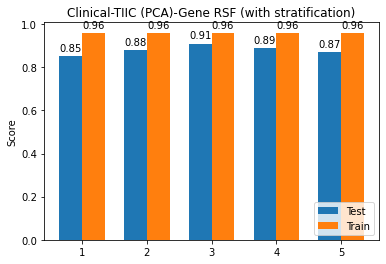

In [159]:
#plot the scores
labels=['1','2','3','4','5']
x=np.arange(len(labels))
width=0.35

fig,ax=plt.subplots()
rects1=ax.bar(x-width/2,np.round(recordsn_g['test score'],2),
              width,label='Test')
rects2=ax.bar(x+width/2,np.round(recordsn_g['train score'],2),
              width,label='Train')

ax.set_ylabel('Score')
ax.set_title('Clinical-TIIC (PCA)-Gene RSF (with stratification)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=4)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)


plt.show()

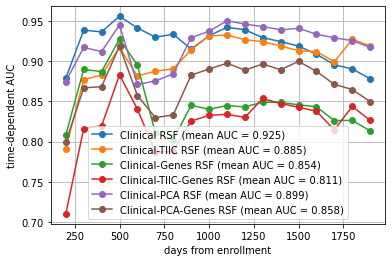

In [134]:
#Compare all RSF models with AUC-ROC
#clinical only
sx_train,sx_test,sy_train,sy_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=42,stratify=strat)
rsf.fit(sx_train,sy_train)
clinical_estimate=rsf.predict(sx_test)
rsf_auc,rsf_mean_auc=cumulative_dynamic_auc(sy_train,sy_test,clinical_estimate,va_times)

#clinical + TIICs
scx_train,scx_test,scy_train,scy_test=train_test_split(
    combined,data_y,train_size=0.8,test_size=0.2,random_state=42,stratify=strat)
rsf.fit(scx_train,scy_train)
clinical_TIIC_estimate=rsf.predict(scx_test)
clinical_TIIC_auc,clinical_TIIC_mean_auc=cumulative_dynamic_auc(scy_train,
                                                                scy_test,
                                                                clinical_TIIC_estimate,va_times)
#clinical+genes
sclxg_train,sclxg_test,sclyg_train,sclyg_test=train_test_split(clcombinedg,data_y,train_size=0.8,test_size=0.2,
                                                            random_state=42,stratify=strat)
rsf.fit(sclxg_train,sclyg_train)
clinical_TIICg_estimate=rsf.predict(sclxg_test)
clinical_TIICg_auc,clinical_TIICg_mean_auc=cumulative_dynamic_auc(sclyg_train,
                                                                sclyg_test,
                                                                clinical_TIICg_estimate,va_times)
    
#clinical+PCA
scnx_train,scnx_test,scny_train,scny_test=train_test_split(
    combined_new,data_y,train_size=0.8,test_size=0.2,random_state=42,stratify=strat)        
rsf.fit(scnx_train,scny_train)
clinical_PCA_estimate=rsf.predict(scnx_test)
clinical_PCA_auc,clinical_PCA_mean_auc=cumulative_dynamic_auc(scny_train,
                                                             scny_test,
                                                             clinical_PCA_estimate,
                                                             va_times)
#clinical+TIIC+gene
scxg_train,scxg_test,scyg_train,scyg_test=train_test_split(combined_g,data_y,train_size=0.8,test_size=0.2,
                                                           random_state=42,stratify=strat)
rsf.fit(scxg_train,scyg_train)
gene_estimate=rsf.predict(scxg_test)
gene_auc,gene_mean_auc=cumulative_dynamic_auc(scyg_train,scyg_test,
                                                          gene_estimate,va_times)

#clinical+TIIC (PCA)+gene
scxng_train,scxng_test,scyng_train,scyng_test=train_test_split(
    combinedn_g,data_y,train_size=0.8,test_size=0.2,random_state=42,stratify=strat)
rsf.fit(scxng_train,scyng_train)
genen_estimate=rsf.predict(scxng_test)
genen_auc,genen_mean_auc=cumulative_dynamic_auc(scyng_train,scyng_test,
                                                          genen_estimate,va_times)

                                                          
plt.plot(va_times, rsf_auc, "o-", 
         label="Clinical RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.plot(va_times, clinical_TIIC_auc, "o-", 
         label="Clinical-TIIC RSF (mean AUC = {:.3f})".format(clinical_TIIC_mean_auc))
plt.plot(va_times, clinical_TIICg_auc, "o-", 
         label="Clinical-Genes RSF (mean AUC = {:.3f})".format(clinical_TIICg_mean_auc))
plt.plot(va_times, gene_auc, "o-", 
         label="Clinical-TIIC-Genes RSF (mean AUC = {:.3f})".format(gene_mean_auc))
plt.plot(va_times, clinical_PCA_auc, "o-", 
         label="Clinical-PCA RSF (mean AUC = {:.3f})".format(clinical_PCA_mean_auc))
plt.plot(va_times, genen_auc, "o-", 
         label="Clinical-PCA-Genes RSF (mean AUC = {:.3f})".format(genen_mean_auc))

plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)